### Logistic regression Model
**Objective:** Building a Logistic regression model to see if we can predict verified_status from remaining variables

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

In [13]:
df = pd.read_csv('tiktok_dataset.csv')

In [3]:
df.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [14]:
# remove rows with unknown claim_status
df.dropna(axis=0,inplace=True)

In [5]:
df.duplicated().sum()

0

In [6]:
df.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19084.000000,1.908400e+04,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9542.500000,5.624840e+09,32.423811,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5509.220604,2.537030e+09,16.226470,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4771.750000,3.425100e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9542.500000,5.609500e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14313.250000,7.840823e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19084.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


### Handling outliers

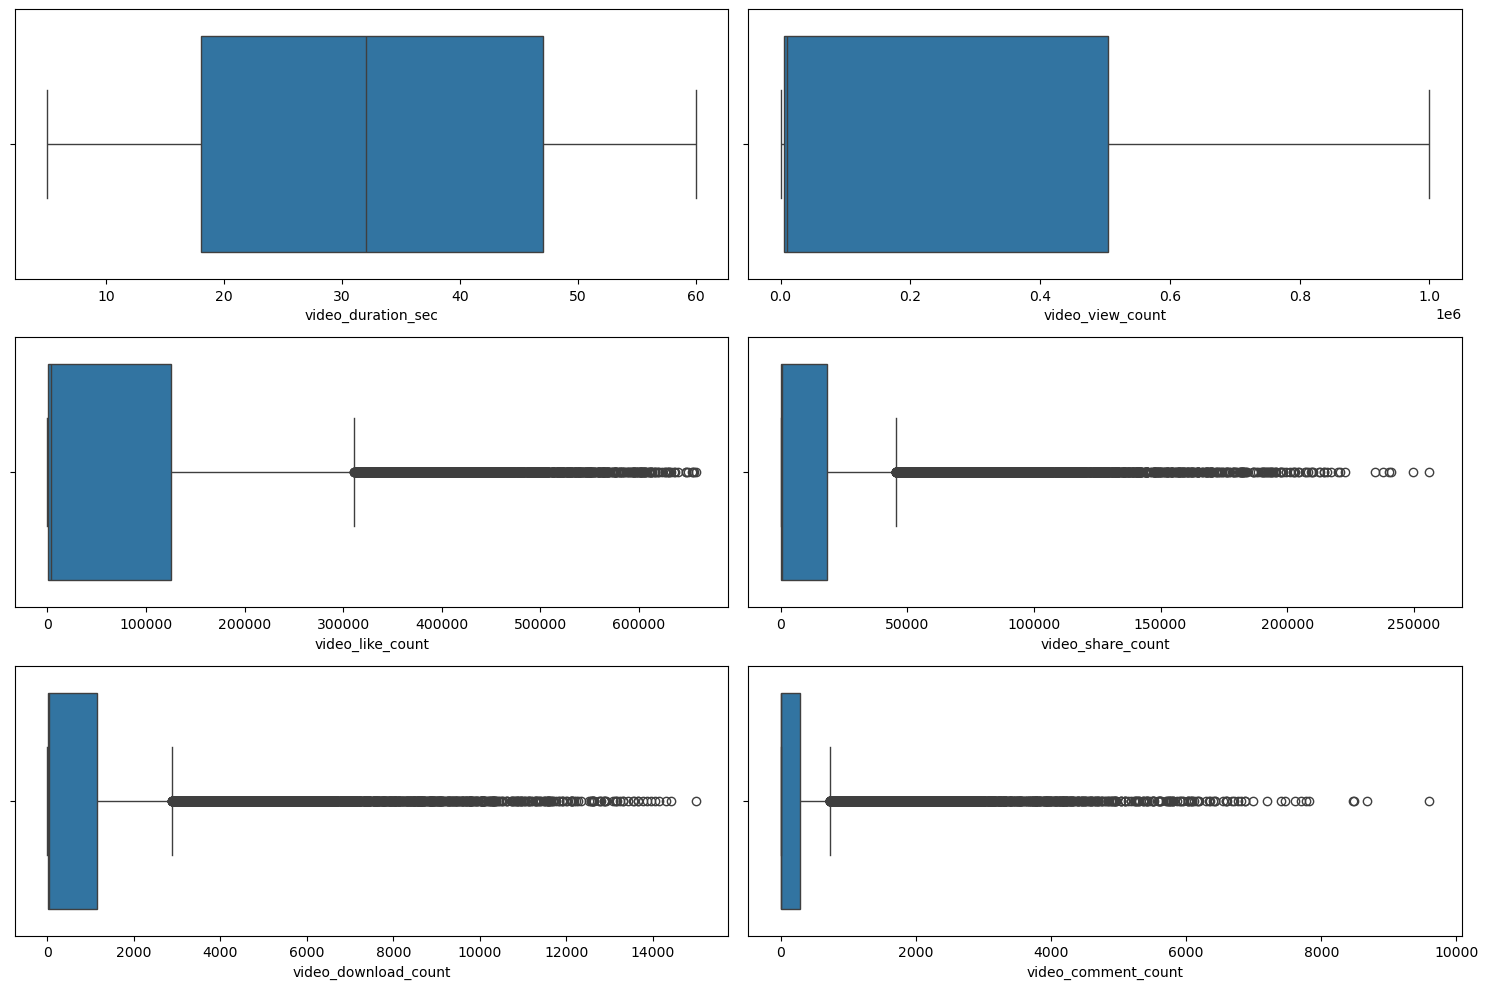

In [16]:
#Previously we have obeserved that all the video_counts have outliers
num_cols  = ['video_duration_sec','video_view_count','video_like_count','video_share_count','video_download_count','video_comment_count']
n = len(num_cols)
nrows = (n // 2) if (n % 2 == 0) else (n // 2 + 1)
fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(5 * nrows, 10))
for i,col in enumerate(num_cols):
    sns.boxplot(df[col],ax=ax[i//2, i%2],orient='h')
plt.tight_layout()

In [60]:
df.shape

(19084, 12)

#### Outlier Imputations

1. Impute features where outliers distort relationships or lead to multicollinearity issues, using methods like capping or transformations.
2. Retain outliers in features where they represent important real-world variations and are crucial for capturing the full scope of the data.
3. Evaluate the impact of your choices on model performance and data integrity, and adjust as needed.

In [17]:
count_cols = ['video_like_count','video_share_count','video_download_count','video_comment_count']
#count_cols = ['video_like_count','video_comment_count']

for column in count_cols:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    median = df[column].median()
    outlier_threshold = q3 + 1.5*iqr

    # Count the number of values that exceed the outlier threshold
    outlier_count = (df[column] > outlier_threshold).sum()
    print(f'Number of outliers, {column}:', outlier_count)

Number of outliers, video_like_count: 1726
Number of outliers, video_share_count: 2508
Number of outliers, video_download_count: 2450
Number of outliers, video_comment_count: 2789


In [18]:
# we choose to impute the outliers with the q3 + 1.5*iqr ->  meaning iqr_factor value = 1.5
def outlier_imputer(column_list, iqr_factor):
    '''
    Impute upper-limit values in specified columns based on their interquartile range.

    Arguments:
        column_list: A list of columns to iterate over
        iqr_factor: A number representing x in the formula:
                    Q3 + (x * IQR). Used to determine maximum threshold,
                    beyond which a point is considered an outlier.

    The IQR is computed for each column in column_list and values exceeding
    the upper threshold for each column are imputed with the upper threshold value.
    '''
    for col in column_list:
        # Reassign minimum to zero
        df.loc[df[col] < 0, col] = 0

        # Calculate upper threshold
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_threshold = q3 + (iqr_factor * iqr)
        print(col)
        print('q3:', q3)
        print('upper_threshold:', upper_threshold)

        # Reassign values > threshold to threshold
        df.loc[df[col] > upper_threshold, col] = upper_threshold
        print(df[col].describe())
        print()

#### Checking different combinations for selective imputation of the outlier.

After trying multiple combinations of selective imputation , if the features 'video_like_count' and 'video_comment_count' imputations leads to a better VIF values of the features rather then when all the features are imputed.

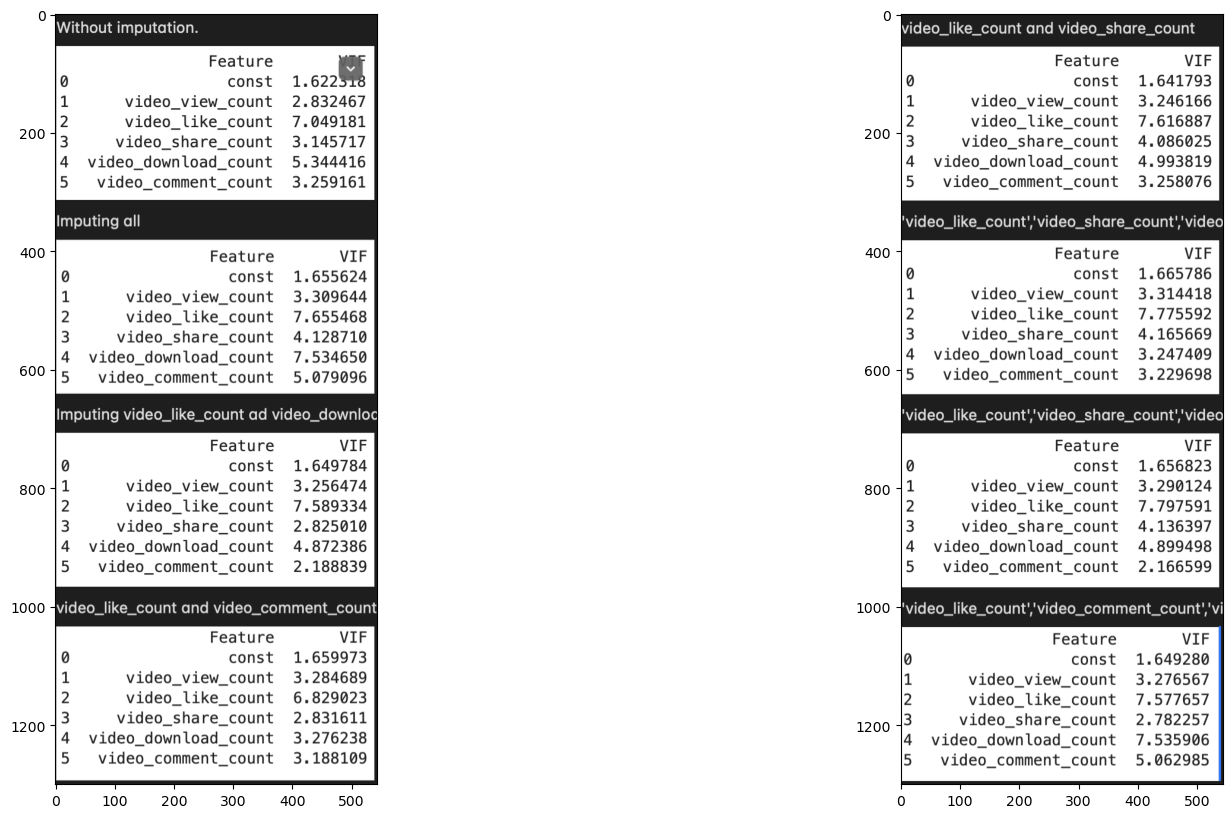

In [111]:
from PIL import Image
img_path = "images/1.png"  # Replace with your actual image filename or path
img = Image.open(img_path)
img2 = Image.open('images/2.png')
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
ax[0].imshow(img)
ax[1].imshow(img2)

In [19]:
count_cols = ['video_like_count','video_comment_count']
outlier_imputer(count_cols,1.5)

video_like_count
q3: 125020.0
upper_threshold: 311333.875
count     19084.000000
mean      74323.538632
std      107103.555220
min           0.000000
25%         810.750000
50%        3403.500000
75%      125020.000000
max      311333.875000
Name: video_like_count, dtype: float64

video_comment_count
q3: 292.0
upper_threshold: 728.5
count    19084.000000
mean       181.023501
std        272.084766
min          0.000000
25%          1.000000
50%          9.000000
75%        292.000000
max        728.500000
Name: video_comment_count, dtype: float64



In [94]:
df.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19084.000000,1.908400e+04,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9542.500000,5.624840e+09,32.423811,254708.558688,83360.009615,13935.842067,878.781073,232.942570
std,5509.220604,2.537030e+09,16.226470,322893.280814,130160.228410,22730.697162,1430.744878,386.322021
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4771.750000,3.425100e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9542.500000,5.609500e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14313.250000,7.840823e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19084.000000,9.999873e+09,60.000000,999817.000000,497647.750000,72543.000000,4604.000000,1165.000000


In [19]:
df['verified_status'].value_counts()

verified_status
not verified    17884
verified         1200
Name: count, dtype: int64

In [75]:
# Check class balance
df["verified_status"].value_counts(normalize=True)

verified_status
not verified    0.93712
verified        0.06288
Name: proportion, dtype: float64

The dataset is very unbalanced based on the target variable 'verified_status'.

We can upsample the minority class by resampling 17884(size of majority class) samples with replacement to give a final balanced dataset.


In [20]:
# Resampling
data_majority = df[df["verified_status"] == "not verified"]
data_minority = df[df["verified_status"] == "verified"]

data_minority_upsampled = resample(data_minority,
                                 replace=True,                 # to sample with replacement
                                 n_samples=len(data_majority), # to match majority class
                                 random_state=0)

In [21]:
df1 = pd.concat([data_majority, data_minority_upsampled]).reset_index(drop=True)

df1["verified_status"].value_counts()

verified_status
not verified    17884
verified        17884
Name: count, dtype: int64

In [22]:
# lets try to check effect of the transcription_text on verified_status
df1['text_length']=df1['video_transcription_text'].apply(len)

In [23]:
df1.groupby(['verified_status']).agg({'text_length':'mean'})

,text_length
verified_status,
not verified,89.401141
verified,84.569559


<Axes: xlabel='text_length', ylabel='Count'>

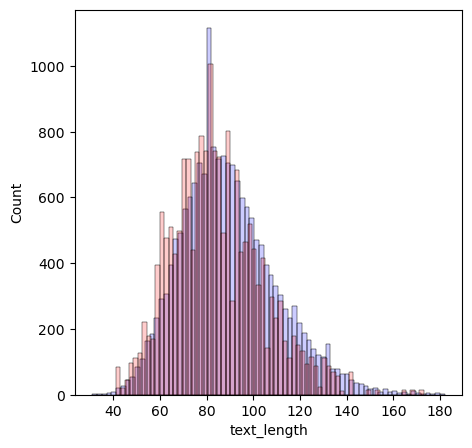

In [24]:
plt.figure(figsize=(5,5))
sns.histplot(x='text_length',data=df1[df1['verified_status']=='not verified'],alpha=0.2,color='blue',label='not verified')
sns.histplot(x='text_length',data=df1[df1['verified_status']=='verified'],color='red',label='verified',alpha=0.2)

**Observation:** text_length doesn't seem to help with prediction of verified_status

### Correlation

In [25]:
df1.corr(numeric_only=True).columns

Index(['#', 'video_id', 'video_duration_sec', 'video_view_count',
       'video_like_count', 'video_share_count', 'video_download_count',
       'video_comment_count', 'text_length'],
      dtype='object')

In [27]:
num_cols= ['video_duration_sec', 'video_view_count',
       'video_like_count', 'video_share_count', 'video_download_count',
       'video_comment_count', 'text_length']

<Axes: >

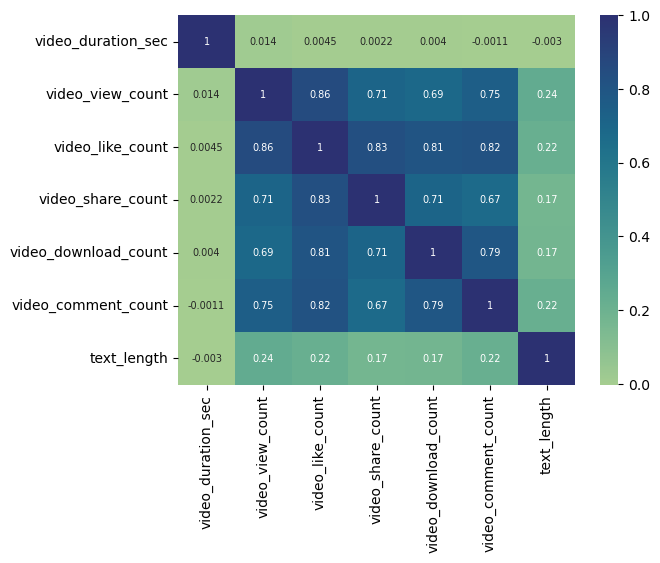

In [28]:
sns.heatmap(df1[num_cols].corr(),annot=True,cmap='crest',annot_kws={'size':7})

**Observation:** 'video_view_count', 'video_like_count', 'video_share_count', 'video_download_count' , 'video_comment_count' seem to be highly correlated.

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [26]:
features = ['video_view_count','video_like_count', 'video_share_count', 'video_download_count','video_comment_count']

In [27]:
X = df[features]

# Add a constant to the model (intercept)
X_with_const = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

print(vif_data)

                Feature       VIF
0                 const  1.659973
1      video_view_count  3.284689
2      video_like_count  6.829023
3     video_share_count  2.831611
4  video_download_count  3.276238
5   video_comment_count  3.188109


In [28]:
# removing video_like_count as vif > 5
features = ['video_view_count', 'video_share_count', 'video_download_count','video_comment_count']
X = df[features]

# Add a constant to the model (intercept)
X_with_const = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

print(vif_data)

                Feature       VIF
0                 const  1.657142
1      video_view_count  2.432605
2     video_share_count  2.201621
3  video_download_count  2.969265
4   video_comment_count  2.946024


### Preparing data for modeling

In [29]:
df1.columns

Index(['#', 'claim_status', 'video_id', 'video_duration_sec',
       'video_transcription_text', 'verified_status', 'author_ban_status',
       'video_view_count', 'video_like_count', 'video_share_count',
       'video_download_count', 'video_comment_count', 'text_length'],
      dtype='object')

In [30]:
y = df1['verified_status']
#x = df1[['claim_status','video_duration_sec','video_download_count','author_ban_status','video_view_count', 'video_share_count','video_comment_count']]
x = df1[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", "video_share_count", "video_download_count", "video_comment_count"]]

x.head()

,video_duration_sec,claim_status,author_ban_status,video_view_count,video_share_count,video_download_count,video_comment_count
0,59,claim,under review,343296.0,241.0,1.0,0.0
1,32,claim,active,140877.0,19034.0,1161.0,684.0
2,31,claim,active,902185.0,2858.0,833.0,329.0
3,25,claim,active,437506.0,34812.0,1234.0,584.0
4,19,claim,active,56167.0,4110.0,547.0,152.0


In [31]:
# train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)

In [32]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((26826, 7), (8942, 7), (26826,), (8942,))

In [33]:
# categorical to numeric
x_train.dtypes

video_duration_sec        int64
claim_status             object
author_ban_status        object
video_view_count        float64
video_share_count       float64
video_download_count    float64
video_comment_count     float64
dtype: object

In [34]:
x_train['author_ban_status'].unique()

array(['active', 'under review', 'banned'], dtype=object)

In [35]:
x_train_encode = x_train[['claim_status','author_ban_status']]
x_train_encode.head()

,claim_status,author_ban_status
33058,opinion,active
20491,opinion,active
25583,opinion,active
18474,opinion,active
27312,opinion,active


In [36]:
x_encoder = OneHotEncoder(drop='first',sparse_output=False)
x_train_encoded = x_encoder.fit_transform(x_train_encode)

In [37]:
x_encoder.get_feature_names_out()

array(['claim_status_opinion', 'author_ban_status_banned',
       'author_ban_status_under review'], dtype=object)

In [38]:
x_train_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [39]:
x_train_encoded_df = pd.DataFrame(data = x_train_encoded,columns=x_encoder.get_feature_names_out())
x_train_encoded_df

,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
26821,1.0,0.0,0.0
26822,1.0,0.0,0.0
26823,1.0,0.0,0.0
26824,1.0,0.0,0.0


In [40]:
x_train

,video_duration_sec,claim_status,author_ban_status,video_view_count,video_share_count,video_download_count,video_comment_count
33058,33,opinion,active,2252.0,23.0,4.0,0.0
20491,52,opinion,active,6664.0,550.0,53.0,2.0
25583,37,opinion,active,6327.0,257.0,3.0,0.0
18474,57,opinion,active,1702.0,28.0,0.0,0.0
27312,21,opinion,active,3842.0,101.0,1.0,0.0
...,...,...,...,...,...,...,...
20757,36,opinion,active,8848.0,441.0,24.0,1.0
32103,25,opinion,active,8821.0,134.0,8.0,1.0
30403,26,opinion,active,958.0,21.0,2.0,0.0
21243,32,opinion,active,8553.0,744.0,62.0,23.0


In [41]:
x_train_final = pd.concat([x_train.drop(columns = ['claim_status','author_ban_status']).reset_index(drop=True),x_train_encoded_df],axis=1)
x_train_final.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,33,2252.0,23.0,4.0,0.0,1.0,0.0,0.0
1,52,6664.0,550.0,53.0,2.0,1.0,0.0,0.0
2,37,6327.0,257.0,3.0,0.0,1.0,0.0,0.0
3,57,1702.0,28.0,0.0,0.0,1.0,0.0,0.0
4,21,3842.0,101.0,1.0,0.0,1.0,0.0,0.0


In [42]:
y_train.values.reshape(-1,1)

array([['verified'],
       ['verified'],
       ['verified'],
       ...,
       ['verified'],
       ['verified'],
       ['not verified']], dtype=object)

In [43]:
# encoding y variable
y_encoder = OneHotEncoder(drop='first', sparse_output=False)
# Notes:
#   - Adjusting the shape of `y_train` before passing into `.fit_transform()`, since it takes in 2D array
#   - Using `.ravel()` to flatten the array returned by `.fit_transform()`, so that it can be used later to train the model
y_train_final = y_encoder.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# Display the encoded training outcome variable
y_train_final

array([1., 1., 1., ..., 1., 1., 0.])

In [44]:
x_test_to_encode = x_test[["claim_status", "author_ban_status"]]

x_test_encoded = x_encoder.transform(x_test_to_encode)

x_test_encoded_df = pd.DataFrame(data=x_test_encoded, columns=x_encoder.get_feature_names_out())

x_test_final = pd.concat([x_test.drop(columns=["claim_status", "author_ban_status"]).reset_index(drop=True), x_test_encoded_df], axis=1)

In [45]:
# Encode the testing outcome variable
# Notes:
#   - Adjusting the shape of `y_test` before passing into `.transform()`, since it takes in 2D array
#   - Using `.ravel()` to flatten the array returned by `.transform()`, so that it can be used later to compare with predictions
y_test_final = y_encoder.transform(y_test.values.reshape(-1, 1)).ravel()

# Display the encoded testing outcome variable
y_test_final

array([1., 1., 1., ..., 0., 1., 1.])

In [46]:
x_test_final.shape,x_train_final.shape

((8942, 8), (26826, 8))

In [47]:
x_train_final.describe()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
count,26826.000000,26826.000000,26826.000000,26826.000000,26826.000000,26826.00000,26826.000000,26826.000000
mean,32.074890,178195.871282,12003.175464,725.806307,127.254641,0.65101,0.062514,0.089130
std,16.135485,291556.578310,27903.187679,1729.103052,241.421236,0.47666,0.242091,0.284937
min,5.000000,20.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,18.000000,3760.000000,72.000000,4.000000,1.000000,0.00000,0.000000,0.000000
50%,32.000000,7597.000000,312.000000,19.000000,3.000000,1.00000,0.000000,0.000000
75%,46.000000,285241.250000,6545.000000,398.000000,91.000000,1.00000,0.000000,0.000000
max,60.000000,999817.000000,249672.000000,14994.000000,728.500000,1.00000,1.000000,1.000000


### Modeling

#### 1. Using logistic regression from sklearn

In [48]:
log_clf = LogisticRegression(random_state=0, max_iter=800).fit(x_train_final, y_train_final)
y_pred = log_clf.predict(x_test_final)

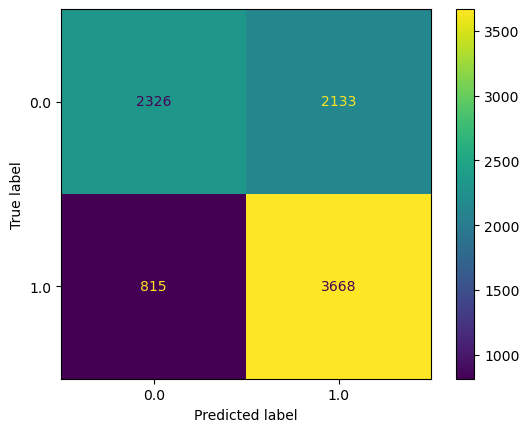

In [49]:
# confusion matrix
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test_final, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

In [50]:
# Create classification report for logistic regression model
target_labels = ["verified", "not verified"]
print(classification_report(y_test_final, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

    verified       0.74      0.52      0.61      4459
not verified       0.63      0.82      0.71      4483

    accuracy                           0.67      8942
   macro avg       0.69      0.67      0.66      8942
weighted avg       0.69      0.67      0.66      8942



#### Model interpretation

Not verified: 0 , Verified: 1


1. **True Negatives (TN)(2326):** These are the instances where the model correctly predicted accounts as “not verified”. This means the model correctly identified 2326 accounts as “not verified”.
2. **False Positives (FP)(2133):** These are the instances where the model incorrectly predicted accounts as “verified” when they were actually “not verified”. This means the model incorrectly classified 2133 “not verified” accounts as “verified”.
3. **False Negative (FN)(815):** These are the instances where the model incorrectly predicted accounts as “not verified” when they were actually “verified”.
The model incorrectly classified 815 “verified” accounts as “not verified”.
4. **True Positvive (TP)(3668):**
The lower-right quadrant displays the number of true positives. These are the instances where the model correctly predicted accounts as “verified”.
The model correctly identified 3668 accounts as “verified”.

#### Scores:

The precision, recall, & f1-scores are taken from the “not verified” row of the output because that is the target class we are most interested in predicting. 


1. **Precision (0.63):** The precision of 0.61 for the “not verified” class indicates that when the model predicts an account as “not verified”, it is correct about 61% of the time.
2. **Recall (0.82):** The recall of 0.84 for the “not verified” class indicates that the model captures 84% of the actual “not verified” accounts.This high recall highlights the model’s ability to capture “not verified” accounts effectively.
3. **F1-Score (0.71):** In our case, the F1-score is 0.71, which indicates moderate performance in identifying “not verified” accounts.
4. **Accuracy (0.65):** Since the data has been upsampled and is now balanced, using the accuracy metric is appropriate.The accuracy of 0.65 indicates that the model correctly predicts the verification status of accounts 65% of the time.
While this accuracy is relatively low, it should be considered in combination with other metrics such as precision, recall, and F1-score.

In [60]:
# Get the feature names from the model and the model coefficients (which represent log-odds ratios)
# Place into a DataFrame for readability
mod_coeffs = pd.DataFrame(data={"Feature Name":log_clf.feature_names_in_, "Model Coefficient (Logit)":log_clf.coef_[0]})
pd.options.display.float_format = '{:.6f}'.format

mod_coeffs = mod_coeffs.sort_values(by='Model Coefficient (Logit)',
                                                    ascending=False).reset_index(drop=True)
mod_coeffs

,Feature Name,Model Coefficient (Logit)
0,claim_status_opinion,1.702612
1,video_comment_count,0.000448
2,video_share_count,0.000005
3,video_view_count,-0.000000
4,video_download_count,-0.000081
5,video_duration_sec,-0.002454
6,author_ban_status_under review,-0.098664
7,author_ban_status_banned,-0.448430


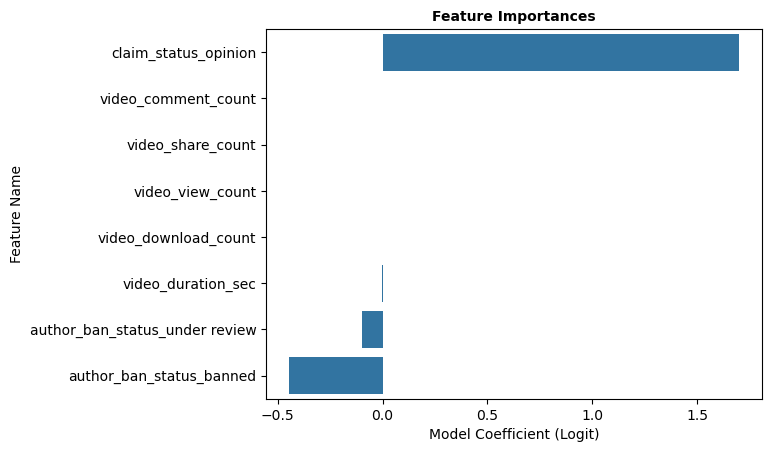

In [62]:
# Plot bar graph for feature importances
sns.barplot(data=mod_coeffs, x='Model Coefficient (Logit)', y='Feature Name')
plt.title('Feature Importances', size=10, weight='bold');

#### Feature Importance

1. **claim_status_opinion(1.7026):** positive coefficient for the feature claim_status_opinion suggests that when the claim_status is “opinion”, the log odds of being a verified user increases slightly by 1.7026 compared to when the claim_status is “claim”
2. **video_duration_sec(-0.002454):** The negative coefficient indicates that with each additional second of video duration, the log-odds of being a verified user decreases by 0.002454 units.
3. **author_ban_status_under_review(-0.098664):** The negative coefficient indicates that when the author_ban_status is under_review, the log-odds of being a verified user decreases by 0.098664 units compared to when the author_ban_status is 'active'.
4. **author_ban_status_banned(-0.448430):** The negative coefficient indicates that when the author_ban_status is banned, the log-odds of being a verified user decreases by 0.448430 units compared to when the author_ban_status is 'active'.

Features such as video_view_count, video_share_count, video_comment_count, video_download_count have coefficients very close to zero, suggesting they contribute very little to the model and have less influence on the prediction.

#### 2. Using Logit from statsmodels

In [53]:
import statsmodels.api as sm

# Fit the logistic regression model
logit_model = sm.Logit(y_train_final, x_train_final)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.625800
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                26826
Model:                          Logit   Df Residuals:                    26818
Method:                           MLE   Df Model:                            7
Date:                Sat, 31 Aug 2024   Pseudo R-squ.:                 0.09716
Time:                        15:29:13   Log-Likelihood:                -16788.
converged:                       True   LL-Null:                       -18594.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
video_duration_sec                -0.0097      0.001    -13.700     

In [64]:
result.params

video_duration_sec               -0.009743
video_view_count                 -0.000001
video_share_count                 0.000005
video_download_count             -0.000041
video_comment_count              -0.000165
claim_status_opinion              0.903268
author_ban_status_banned         -0.482845
author_ban_status_under review   -0.267619
dtype: float64

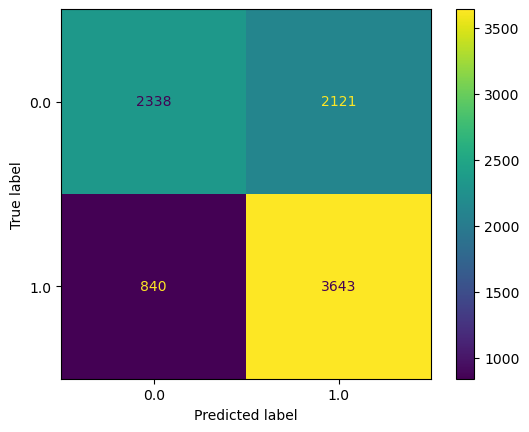

In [55]:
# Predict probabilities
predictions = result.predict(x_test_final)

# Convert probabilities to binary outcomes
predicted_classes = (predictions > 0.5).astype(int)

# Compute values for confusion matrix
log_cm = confusion_matrix(y_test_final, predicted_classes, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

In [66]:
target_labels = ["verified", "not verified"]
print(classification_report(y_test_final, predicted_classes, target_names=target_labels))
pd.DataFrame(data={"Feature Name":log_clf.feature_names_in_, "Model Coefficient":result.params}).sort_values(by='Model Coefficient',ascending=False)

              precision    recall  f1-score   support

    verified       0.74      0.52      0.61      4459
not verified       0.63      0.81      0.71      4483

    accuracy                           0.67      8942
   macro avg       0.68      0.67      0.66      8942
weighted avg       0.68      0.67      0.66      8942



,Feature Name,Model Coefficient
claim_status_opinion,claim_status_opinion,0.903268
video_share_count,video_share_count,0.000005
video_view_count,video_view_count,-0.000001
video_download_count,video_download_count,-0.000041
video_comment_count,video_comment_count,-0.000165
video_duration_sec,video_duration_sec,-0.009743
author_ban_status_under review,author_ban_status_under review,-0.267619
author_ban_status_banned,author_ban_status_banned,-0.482845


### Model Interpretation

The values of the scores and the coefficients follow same pattern as that of sklearn logistic regression model. So the model interpretation is the same. Additionally we have std errors of the model coefficients that show the statistical significance of these model coefficients with p-values.